In [9]:
import pandas as pd
import os
import boto3
from io import StringIO
from biopandas.pdb import PandasPdb



In [2]:
# Define S3 path
bucket = 'bbio-data-platform'
key = 'dev/ab-discovery/parapred/NI006_Fv_paragraph_pred.csv'

# Initialize S3 client (uses your AWS credentials)
s3 = boto3.client('s3')

# Fetch the object
response = s3.get_object(Bucket=bucket, Key=key)

# Read into Pandas
csv_content = response['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(csv_content))


In [3]:
df['pred'].dtype

dtype('float64')

In [4]:
# import pandas as pd
import numpy as np

# Example DataFrame
# df = pd.DataFrame({'residue': [1, 2, 3, 4], 'score': [0.12, 0.45, 0.89, 0.67]})

# Apply background gradient (0–1 scale)
styled = df.style.background_gradient(subset=['pred'], cmap='RdYlGn', vmin=0, vmax=1)

# In Jupyter this renders as a color-formatted table
styled


,pdb,chain_type,chain_id,IMGT,AA,atom_num,x,y,z,pred
0,NI006_Fv_structure_imgt,H,H,25,VAL,340,-17.205000,2.004000,3.310000,0.014362
1,NI006_Fv_structure_imgt,H,H,26,SER,356,-18.378000,5.323000,4.970000,0.008897
2,NI006_Fv_structure_imgt,H,H,27,GLY,367,-18.440000,9.011000,3.529000,0.105539
3,NI006_Fv_structure_imgt,H,H,28,GLY,374,-18.800000,8.041000,0.110000,0.199427
4,NI006_Fv_structure_imgt,H,H,29,SER,381,-20.481000,5.347000,-1.939000,0.251171
5,NI006_Fv_structure_imgt,H,H,30,ILE,392,-18.754000,2.070000,-2.887000,0.180706
6,NI006_Fv_structure_imgt,H,H,31,ILE,411,-20.274000,2.360000,-6.166000,0.696692
7,NI006_Fv_structure_imgt,H,H,34,SER,430,-18.373000,4.948000,-7.467000,0.779182
8,NI006_Fv_structure_imgt,H,H,35,ARG,441,-17.131000,4.446000,-11.146000,0.953349
9,NI006_Fv_structure_imgt,H,H,36,SER,465,-13.556000,5.834000,-10.285000,0.942694


In [5]:
df.columns

Index(['pdb', 'chain_type', 'chain_id', 'IMGT', 'AA', 'atom_num', 'x', 'y',
       'z', 'pred'],
      dtype='object')

In [10]:
# Join ParaSurf predictions 
bucket = 'bbio-data-platform'
key = 'dev/ab-discovery/parasurf/NI006_Fv_structure_imgt_parasurf_pred/NI006_pred.pdb'

s3 = boto3.client('s3')

# Fetch the object

# Fetch the object and decode as string
response = s3.get_object(Bucket=bucket, Key=key)
pdb_text = response['Body'].read().decode('utf-8')

# Load PDB into PandasPdb using in-memory string buffer
ppdb = PandasPdb()
ppdb.read_pdb_from_list(StringIO(pdb_text).readlines())

# Access ATOM data as DataFrame
df_atoms = ppdb.df['ATOM']

In [12]:
df_atoms.columns

Index(['record_name', 'atom_number', 'blank_1', 'atom_name', 'alt_loc',
       'residue_name', 'blank_2', 'chain_id', 'residue_number', 'insertion',
       'blank_3', 'x_coord', 'y_coord', 'z_coord', 'occupancy', 'b_factor',
       'blank_4', 'segment_id', 'element_symbol', 'charge', 'line_idx'],
      dtype='object')

In [18]:
df_parasurf = df_atoms[['chain_id','residue_number','b_factor']].drop_duplicates()

In [19]:
df_parasurf.shape

(227, 3)

In [20]:
df_parasurf

,chain_id,residue_number,b_factor
0,H,1,0.710
9,H,2,0.544
16,H,3,0.005
25,H,4,0.001
33,H,5,0.030
...,...,...,...
1671,L,123,0.000
1680,L,124,0.000
1687,L,125,0.000
1696,L,126,0.000


In [21]:
styled_parasurf = df_parasurf.style.background_gradient(subset=['b_factor'], cmap='RdYlGn', vmin=0, vmax=1)

styled_parasurf

,chain_id,residue_number,b_factor
0,H,1,0.710000
9,H,2,0.544000
16,H,3,0.005000
25,H,4,0.001000
33,H,5,0.030000
42,H,6,0.005000
51,H,7,0.004000
57,H,8,0.009000
61,H,9,0.004000
68,H,11,0.002000


In [23]:
df_merged=df.merge(df_parasurf, how='left', left_on=['chain_id', 'IMGT'], right_on=['chain_id', 'residue_number'])

In [25]:
df_merged=df_merged[['chain_id', 'IMGT', 'pred', 'b_factor']]

In [27]:
df_merged.rename(columns={'pred': 'paragraph', 'b_factor': 'parasurf'}, inplace=True)


In [28]:
styled2 = df_merged.style.background_gradient(subset=['paragraph', 'parasurf'], cmap='RdYlGn', vmin=0, vmax=1)


In [29]:
styled2

,chain_id,IMGT,paragraph,parasurf
0,H,25,0.014362,0.001000
1,H,26,0.008897,0.008000
2,H,27,0.105539,0.393000
3,H,28,0.199427,0.173000
4,H,29,0.251171,0.497000
5,H,30,0.180706,0.031000
6,H,31,0.696692,0.324000
7,H,34,0.779182,0.685000
8,H,35,0.953349,0.957000
9,H,36,0.942694,0.941000


In [30]:
import seaborn as sns

In [34]:
df_merged1=df_merged[(df_merged['parasurf']>0.70)&(df_merged['paragraph']>0.70)]

In [37]:
df_merged1

,chain_id,IMGT,paragraph,parasurf
8,H,35,0.953349,0.957
9,H,36,0.942694,0.941
11,H,38,0.974385,0.991
17,H,57,0.984921,0.920
19,H,59,0.872847,0.818
21,H,64,0.959532,0.952
23,H,66,0.975078,0.984
29,H,107,0.844585,0.957
30,H,108,0.880313,0.889
31,H,109,0.980045,0.972


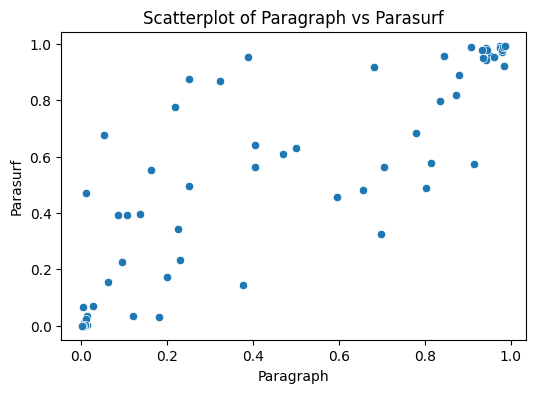

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot of 'paragraph' vs 'parasurf'
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_merged, x='paragraph', y='parasurf')
plt.xlabel('Paragraph')
plt.ylabel('Parasurf')
plt.title('Scatterplot of Paragraph vs Parasurf')
plt.show()